In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
n_test = 3
nstates = 4
n_states = 4
getidx = 0
model_name = "fun"
model_name = "sch"
%pwd


'D:\\code\\GraphVampNet-main\\GraphVampNet-main'

In [22]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [23]:
def estimate_koopman_op(trajs, tau, is_list = False):
    if type(trajs) == list or is_list:
        traj = np.concatenate([t[:-tau] for t in trajs], axis=0)
        traj_lag = np.concatenate([t[tau:] for t in trajs], axis=0)
    else:
        traj = trajs[:-tau]
        traj_lag = trajs[tau:]
    c_0 = np.transpose(traj)@traj
    c_tau = np.transpose(traj)@traj_lag
    
    eigv, eigvec = np.linalg.eig(c_0)
    include = eigv > 1e-7
    eigv = eigv[include]
    eigvec = eigvec[:, include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    koopman_op = c0_inv @ c_tau
    return koopman_op

In [24]:
def get_its(traj, lags):
    '''
    implied timescales from a trajectory estimated at a series of lag times
    
    parameters:
    ----------
    traj: [traj_timesteps, traj_dimensions]
    lags: [lagtimes]
    
    returns:
    ----------
    its: [traj_dim-1, lagtimes]
    '''
    if type(traj) == list:
        outputsize = traj[0].shape[1]
    else:
        outputsize = traj.shape[1]
    its = np.zeros((outputsize-1, len(lags)))
    
    for t, tau_lag in enumerate(lags):
        koopman_op = estimate_koopman_op(traj, tau_lag)
        k_eigvals, k_eigvec = np.linalg.eig(np.real(koopman_op))
        k_eigvals = np.sort(np.absolute(k_eigvals))
        k_eigvals = k_eigvals[:-1]
        its[:,t] = (-tau_lag/np.log(k_eigvals))
    return its

In [25]:
transformed = [] #[n_test, n_traj, n_frame]
for i in range(1,n_test+1):
    trans_temp = []
    trans_temp= (np.load('src/ab_sch4_%i/transformed.npz'%i,allow_pickle=True)['arr_0'])
    transformed.append(trans_temp)


In [27]:
# take the argmax of each prob vector for hard state assignment
all_trajs = [] #(n_test, n_traj, n_frame) int,max output state
for i in range(len(transformed)):
    trajs = []
    for j in range(len(transformed[i])): # 1 trajectory
        traj = []
        for k in range(len(transformed[i][j])): # length of each trajectory
            traj.append(transformed[i][j][k].argmax()) #value of max state
        traj = np.array(traj)
        trajs.append(traj)
    
    all_trajs.append(trajs)

In [ ]:
output_size = nstates
#n_states, trj, frame, #value
all_indexs = [[] for i in range(output_size)] #[n_states, n_traj, 1, nxxx]
all_states_num = [0 for i in range(output_size)]
all_states_prob=[]
for trj in range(len(transformed[getidx])):

    states_prob = transformed[getidx][trj]
    all_states_prob.append(states_prob)
    # Order the output states based on their population
    coor_pred = np.argmax(states_prob,  axis = 1) #max, states
    #每一类属于的下标
    indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)] #[n_states, nxxx], frame idx
    states_num = [len(i[0]) for i in indexes]
    all_states_num =  [all_states_num[i] + states_num[i] for i in range(output_size)]
    for i in range(output_size):
        all_indexs[i].append(indexes[i])

In [ ]:
states_order =  np.argsort(all_states_num).astype('int')[::-1]

In [ ]:
state_prob0 = [all_states_num[i]/sum(all_states_num) for i in range(n_states)]
state_prob0

In [29]:
new_index = np.array(all_indexs)[states_order]


In [32]:
output_size = nstates
#n_states, trj, frame, #value
all_indexs = [[] for i in range(output_size)] #[n_states, n_traj, 1, nxxx]
all_states_num = [0 for i in range(output_size)]
all_states_prob=[]
for trj in range(len(transformed[getidx])):

    states_prob = transformed[getidx][trj]
    all_states_prob.append(states_prob)
    # Order the output states based on their population
    coor_pred = np.argmax(states_prob,  axis = 1) #max, states
    #
    indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)] #[n_states, nxxx], frame idx
    states_num = [len(i[0]) for i in indexes]
    all_states_num =  [all_states_num[i] + states_num[i] for i in range(output_size)]
    for i in range(output_size):
        all_indexs[i].append(indexes[i])

In [33]:
states_order =  np.argsort(all_states_num).astype('int')[::-1]

In [34]:
state_prob0 = [all_states_num[i]/sum(all_states_num) for i in range(n_states)]
state_prob0

[0.10218937524023723,
 0.10766201916815177,
 0.2672970809389027,
 0.5228515246527082]

In [35]:
new_index = np.array(all_indexs)[states_order]


C:\Users\DS00HY\AppData\Local\Temp\ipykernel_38300\1959108318.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_index = np.array(all_indexs)[states_order]


In [36]:
n_traj = len(transformed[getidx])
max_frame_id = []
max_frame_value=[0 for i in range(output_size)]
for state, n_idx in enumerate(all_indexs):
    va_idx = (-1,-1)
    for trj in range(n_traj):
        idx = all_indexs[state][trj]
        tmp = transformed[getidx][trj][:,state]
        #print(tmp[idx])
        if len(idx[0]) > 0:
            frame_id = idx[0][(tmp[idx]).argmax()]
            if np.max(tmp[idx]) != transformed[getidx][trj][frame_id][state]:
                print("ERROR")
            if transformed[getidx][trj][frame_id][state] > max_frame_value[state]:
                max_frame_value[state] = transformed[getidx][trj][frame_id][state]
                va_idx = (trj, frame_id)
    max_frame_id.append(va_idx)


[(4, 0), (6, 0), (2, 0), (0, 24)]

In [38]:
states_order

array([3, 2, 1, 0])

In [39]:
max_frame_id_order = np.array(max_frame_id)[states_order]
max_frame_id_order

array([[ 0, 24],
       [ 2,  0],
       [ 6,  0],
       [ 4,  0]], dtype=int64)

In [40]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink', 'tab:gray','tab:olive','tab:cyan']

States population: [52.28515247 26.72970809 10.76620192 10.21893752]%


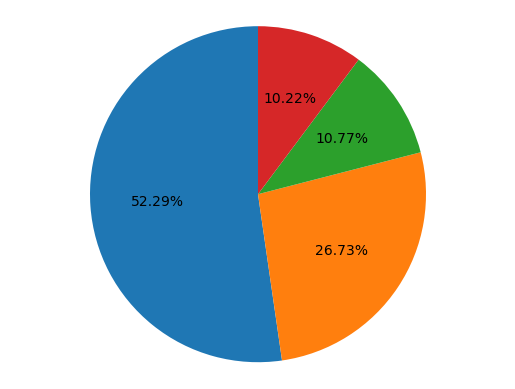

In [41]:

state_prob = np.array(state_prob0)[states_order]
state_prob

fig1, ax1 = plt.subplots()
ax1.pie(np.array(state_prob), autopct='%1.2f%%', startangle=90,colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
print('States population: '+str(np.array(state_prob)*100)+'%')
plt.show()


#%

In [42]:
sorted = np.array(states_order)#np.argsort(state_prob)[::-1] # sort them descending

In [43]:
sorted 

array([3, 2, 1, 0])

In [45]:
# the relation between states of different experiments
state_rel = []
for i in range(n_test):
    rel = []
    for index in sorted:
        count = np.zeros(nstates)
        for j in range(len(all_trajs[i])): # number of trajectories
            #print(i,j)
            if len(all_trajs[0][j]==index) > 0 :
                a = all_trajs[i][j][all_trajs[0][j]==index]
                # count the numbers
                for k in range(nstates):
                    count[k] = count[k] + np.sum([a==k])

        sorted_count = np.argsort(count)[::-1]
        # print(sorted_count, rel)
        # print(sorted_count[0], rel)
        if sorted_count[0] not in rel:
            rel.append(sorted_count[0])
        elif sorted_count[1] not in rel:
            rel.append(sorted_count[1])    
        elif sorted_count[2] not in rel:
            rel.append(sorted_count[2])
        elif sorted_count[3] not in rel:
            rel.append(sorted_count[3])
        elif 4 < len(sorted_count) and sorted_count[4] not in rel:
            rel.append(sorted_count[4])
        elif 5 < len(sorted_count):
            rel.append(sorted_count[5])
        
    rel = np.array(rel)
    state_rel.append(rel)


In [47]:
# sort the states based on the first experiment
all_probs = []
for i in range(n_test): # number of experiments
    trans = transformed[i]
    probs = []
    if i==0:
        for k in range(len(trans)): # number of trajectories
            prob = []
            for j in range(len(trans[k])):
                prob.append(trans[k][j][sorted])
            prob = np.array(prob)
            probs.append(prob)
        all_probs.append(probs)
    else:
        for k in range(len(trans)): # number of trajectories
            prob = []
            for j in range(len(trans[k])):
                prob.append(trans[k][j][state_rel[i-1]])
            prob = np.array(prob)
            probs.append(prob)
        all_probs.append(probs)

In [48]:
lags = np.arange(1,201,2, dtype=np.int32)

In [49]:
its = []
for i in range(n_test): # number of experiments
    its.append(get_its(all_probs[i], lags))

In [50]:
its = np.array(its)

In [51]:
its.shape
# its = np.load('src/abred_all_2/ITS.npy')
# its_nous = np.load('src/abred_all_nous/ITS.npy')
# nstates = 4
# max_tau=250
# lag =  [i for i in range(1, max_tau, 2)]

(3, 3, 100)

In [52]:
mean_its = np.zeros((nstates,100))
up_its = np.zeros((nstates,100))
down_its = np.zeros((nstates,100))

In [53]:
#its = its.T[:,::-1]


In [54]:
for i in range(nstates-1):
    for j in range(len(lags)):
        mean_its[i,j], up_its[i,j], down_its[i,j] = mean_confidence_interval(its[:,i,j])

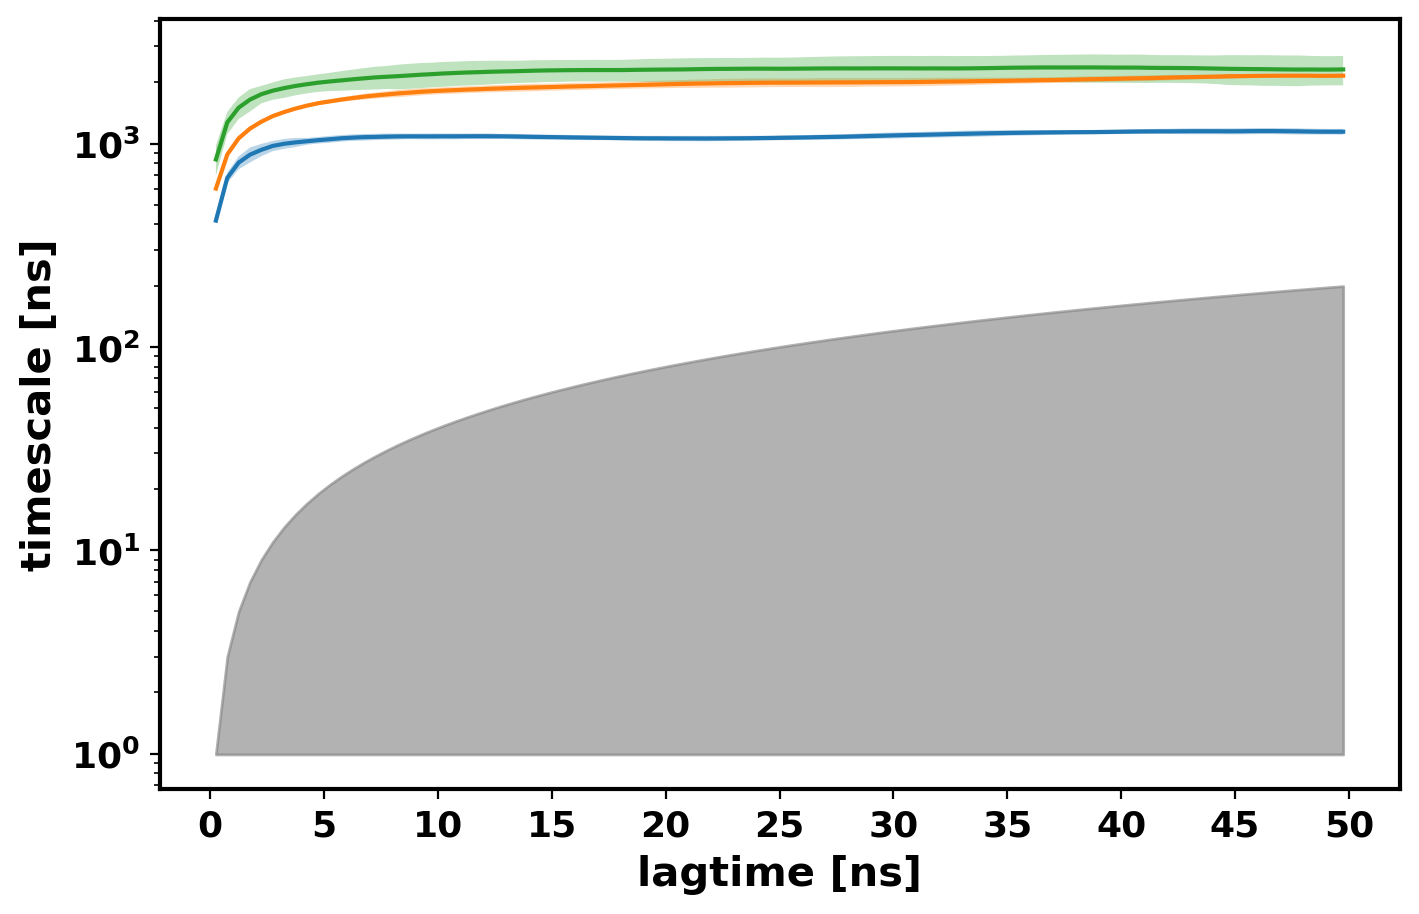

In [55]:
from pylab import *
rc('axes', linewidth=1.5)
f, ax = plt.subplots(1,1, figsize=(8,5), dpi=200)


for index in range(0,nstates):
    ax.semilogy(lags, mean_its[index])
    ax.fill_between(lags, down_its[index], up_its[index], alpha=0.3)



#xlabl = [np.arange(0,41,5).astype(int)]
#ax.set_xticks(np.arange(0,201,20))
#ax.set_xticklabels(xlabl)
ax.set_xticks(np.arange(0,201,20))
ax.set_xticklabels([0,5,10,15,20,25,30,35,40,45,50])
# ax.set_xticks(np.arange(0,201,20))
# ax.set_xticklabels([0,20,40,60,80,100,120,140,160,180,200])
ax.fill_between(lags, lags, 0.99, alpha=0.6, color='grey')

ax.set_xlabel('lagtime [ns]', fontweight='bold', fontsize=15)
ax.set_ylabel('timescale [ns]', fontweight='bold', fontsize=15)


fontsize = 13
ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

plt.savefig('trpcage_ab_its.png')

In [56]:
def get_ck_test(traj, steps, tau, is_list = False):
    if type(traj) == list or is_list:
        n_states = traj[0].shape[1]
    else:
        n_states = traj.shape[1]
    
    predicted = np.zeros((n_states, n_states, steps))
    estimated = np.zeros((n_states, n_states, steps))
    
    predicted[:,:,0] = np.identity(n_states)
    estimated[:,:,0] = np.identity(n_states)
    
    for vector, i in zip(np.identity(n_states), range(n_states)):
        for n in range(1,steps):
            koop = estimate_koopman_op(traj, tau, is_list)
            koop_pred = np.linalg.matrix_power(koop,n)
            koop_est = estimate_koopman_op(traj, tau*n, is_list)
            
            predicted[i,:,n] = vector @ koop_pred
            estimated[i,:,n] = vector @ koop_est
    
    return [predicted, estimated]


In [58]:
preds = []
ests = []
n_steps = 8
tau = 40
for i in range(n_test):
    pred, est = get_ck_test(transformed[i], steps=n_steps, tau=tau, is_list=True)
    preds.append(pred)
    ests.append(est)

In [59]:
preds = np.array(preds)
ests = np.array(ests)

In [60]:
pred_ord = []
est_ord = []
for i in range(n_test):
    pred_ord.append(preds[i][state_rel[i][:,None],state_rel[i][None,:]])
    est_ord.append(ests[i][state_rel[i][:,None],state_rel[i][None,:]])

pred_ord = np.array(pred_ord)
est_ord = np.array(est_ord)

In [61]:
mean_pred = np.zeros((nstates,nstates,n_steps))
up_pred = np.zeros((nstates,nstates,n_steps))
down_pred = np.zeros((nstates,nstates,n_steps))

In [62]:
mean_est = np.zeros((nstates,nstates,n_steps))
up_est = np.zeros((nstates,nstates,n_steps))
down_est = np.zeros((nstates,nstates,n_steps))

In [63]:
for i in range(nstates):
    for j in range(nstates):
        for k in range(n_steps):
            mean_pred[i,j,k], up_pred[i,j,k], down_pred[i,j,k] = mean_confidence_interval(pred_ord[:,i,j,k], confidence=0.95)

In [64]:
for i in range(nstates):
    for j in range(nstates):
        for k in range(n_steps):
            mean_est[i,j,k], up_est[i,j,k], down_est[i,j,k] = mean_confidence_interval(est_ord[:,i,j,k], confidence=0.95)

In [65]:
from matplotlib import rc, rcParams
from pylab import *

rc('axes', linewidth=1.5)
fontsize = 14

In [66]:
# t_md = 0.25
# np.round(np.linspace(0, steps*tau*t_md, 4))

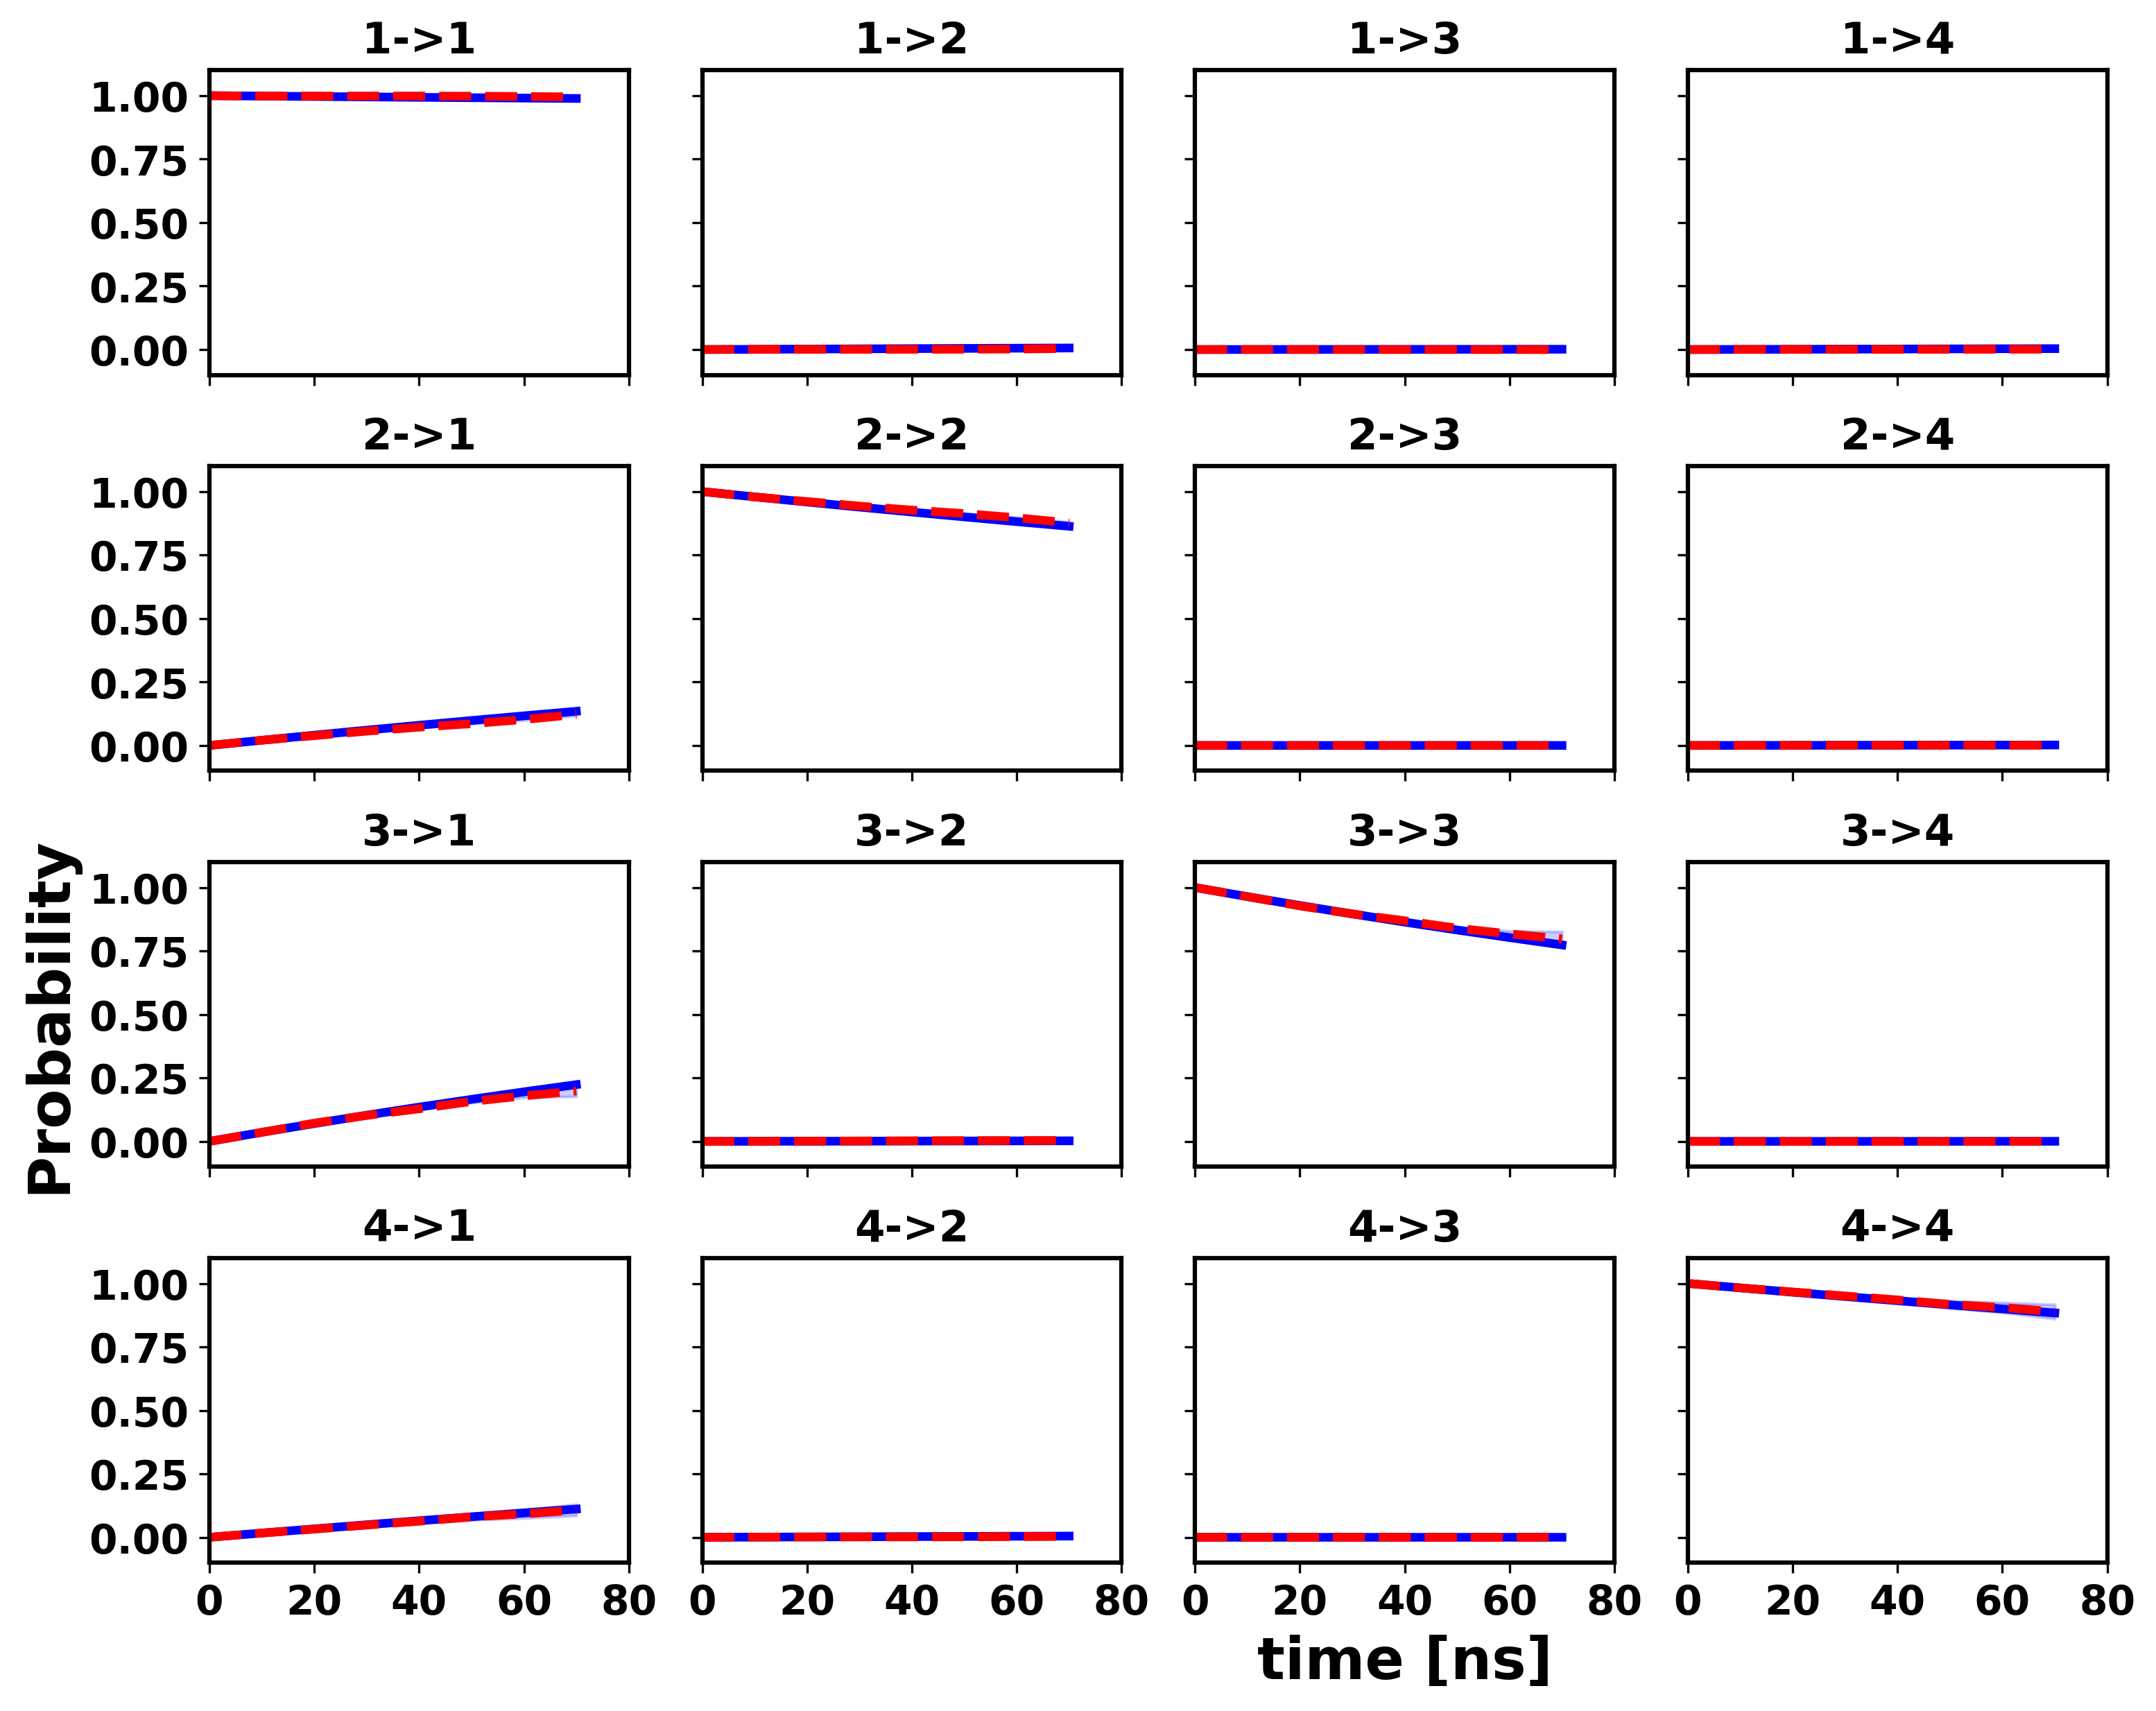

In [67]:
# n_states = 4
steps = n_steps
#tau = 40
pred = mean_pred
est = mean_est
t_md = 0.25
fontsize = 14
fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True, figsize=(10,8),dpi=300)
for index_i in range(n_states):
    for index_j in range(n_states):
        #ax[index_i][index_j].plot(range(0, steps*tau, tau), pred[index_i, index_j], color='r', linestyle='-')
        #ax[index_i][index_j].plot(range(0, steps*tau, tau), est[index_i, index_j], color='b', linestyle='--')

        ax[index_i][index_j].fill_between(range(0, steps*tau, tau), down_est[index_i, index_j], up_est[index_i, index_j], alpha=0.2, color='blue')
        #ax[index_i][index_j].fill_between(range(0, steps*tau, tau), down_pred[index_i, index_j], up_pred[index_i, index_j], alpha=0.2, color='yellow')
        ax[index_i][index_j].set_title(str(index_i+1)+'->'+str(index_j+1), fontweight='bold', fontsize=15)
        #ax[index_i][index_j].errorbar(range(0, steps*tau, tau), est[index_i, index_j], abs(est[index_i,index_j]-down_est[index_i, index_j]), color='red', alpha=0.5)
        ax[index_i][index_j].plot(range(0, steps*tau, tau), pred[index_i, index_j], color='b', linestyle='-', linewidth =3.0)
        ax[index_i][index_j].plot(range(0, steps*tau, tau), est[index_i, index_j], color='r', linestyle='--',linewidth =3.0)

        for tick in ax[index_i][index_j].xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('bold')
        for tick in ax[index_i][index_j].yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('bold')
ax[0][0].set_ylim((-0.1, 1.1))
ax[0][0].set_xlim((0, steps*tau))
ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 5)))
ax[0][0].axes.set_xticklabels(np.round(np.linspace(0, steps*tau*t_md, 5)).astype(int))
#ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 4)))
plt.tight_layout()
#fig.legend(['Estimates', 'Predicted'],loc='lower left', ncol=2,  fontsize=18)
#fig.legend([pred[0], est[0]], ['Estimates', 'Predicted'], 'lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
ax[n_states-1, n_states//2].set_xlabel('time [ns]', fontweight='bold',fontsize=20,ha='center')
ax[n_states//2, 0].set_ylabel('Probability', fontweight='bold', fontsize=20, ha='center')



plt.savefig('ab_%s_%i_ck.png'%(model_name, n_states))

# Attention results

In [68]:
from typing import Tuple, Sequence, List, Union
import itertools

def unflatten(source: np.ndarray, lengths: List[int]) -> List[np.ndarray]:
    """
    Takes an array and returns a list of arrays.

    Parameters
    ----------
    source
        Array to be unflattened.
    lengths
        List of integers giving the length of each subarray.
        Must sum to the length of source.

    Returns
    -------
    unflat
        List of arrays.

    """
    conv = []
    lp = 0
    for arr in lengths:
        arrconv = []
        for le in arr:
            arrconv.append(source[lp:le + lp])
            lp += le
        conv.append(arrconv)
    ccs = list(itertools.chain(*conv))
    return ccs

In [69]:

y_m_t = [] #[n_traj, n_fxx] #
inds = [] #[ n_traj, n_fxx]
thresh = 0.90
exp = getidx #
for i in range(len(transformed[exp])):
    tmp = []
    tmp_ind = []
    for j in range(len(transformed[exp][i])):
        if transformed[exp][i][j].max()>thresh:
            tmp.append(np.argmax(transformed[exp][i][j]))
            tmp_ind.append(j)
    tmp = np.array(tmp)
    tmp_ind = np.array(tmp_ind)
    y_m_t.append(tmp)
    inds.append(tmp_ind)

In [70]:
traj_inds = inds #[ n_traj, n_fxx] #



In [72]:
attn = np.load('src/abred_all_2/total_attn.npz',allow_pickle=True)['arr_0']
inds_con = np.load('intermediate/red_5nbrs_1ns_inds.npy')

In [73]:
inds_con.shape

(1259172, 42, 10)

In [74]:
traj_length = [np.array([len(i) for i in attn])]
traj_length

[array([252, 337, 266, ..., 275, 287, 273])]

In [75]:
inds = [r for r in unflatten(inds_con, traj_length)] #[n_traj, n_frame, n_atmo, n_neighb]



In [77]:
def convert_adj(mat, attn):
    # convert the nbr_adj_list matrix to an adjacency matrix
    adj = np.zeros((mat.shape[0], mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[0]):
        adj[i][np.arange(adj.shape[1])[:,None],mat[i]] = attn[i]
    return adj

In [78]:
print(len(inds), len(attn))
adj=[] #[n_taj, n_atom, n_atom]
for i in range(len(inds)):
    adj.append( convert_adj(inds[i], attn[i]))



5119 5119


In [80]:
n_states = 4
all_scores = [[] for i in range(n_states)] # [n_states]
#all_trajs = [] #[n_test, n_traj, n_frame]
for n_j in range(len(adj)): #for n_traj
    #tmp_scores = []
    for i in range(n_states): #for
        if len(adj[n_j][all_trajs[exp][n_j]==i]) > 0 :
            score =  adj[n_j][all_trajs[exp][n_j]==i].mean(axis=0)
            #tmp_scores.append(score)
            all_scores[i].append(score)

In [81]:
#get avg
sc_core = [np.array(sc) for sc in all_scores]
scores = [sc_core[i].mean(axis=0) for i in range(n_states)]
all_scores[0][0].shape

(42, 42)

In [82]:
sts = [] #[ n_traj]
sts = [ [] for trj in range(n_states)] #[ n_states. n_traj],
for trj in range(len(traj_inds)):
    for i in range(n_states):
        st_0 = traj_inds[trj][y_m_t[trj] == i] #[ n_traj, n_fxx] #
        sts[i].append(st_0)

In [84]:
adjs = []
all_adjs = [ [] for trj in range(n_states)]  #[n_states, n_traj n_states, n_atom, n_atom]
for trj in range(len(traj_inds)):
    for i in range(n_states):

        if len(sts[i][trj]) > 0 and len(adj[trj][sts[i][trj]]) > 0 :
            adj_0 = adj[trj][sts[i][trj]].mean(axis=0)
            all_adjs[i].append(adj_0)

In [85]:
#
sc_adjs = [np.array(sc) for sc in all_adjs]
adjs = [sc_adjs[i].mean(axis=0) for i in range(n_states)]  #[n_states, n_atom, n_atom]


In [87]:
states_order
scores = np.array(scores)[states_order]
#sts = np.array(sts)[states_order]
adjs = np.array(adjs)[states_order]

In [88]:
scores = adjs

<Figure size 640x480 with 0 Axes>

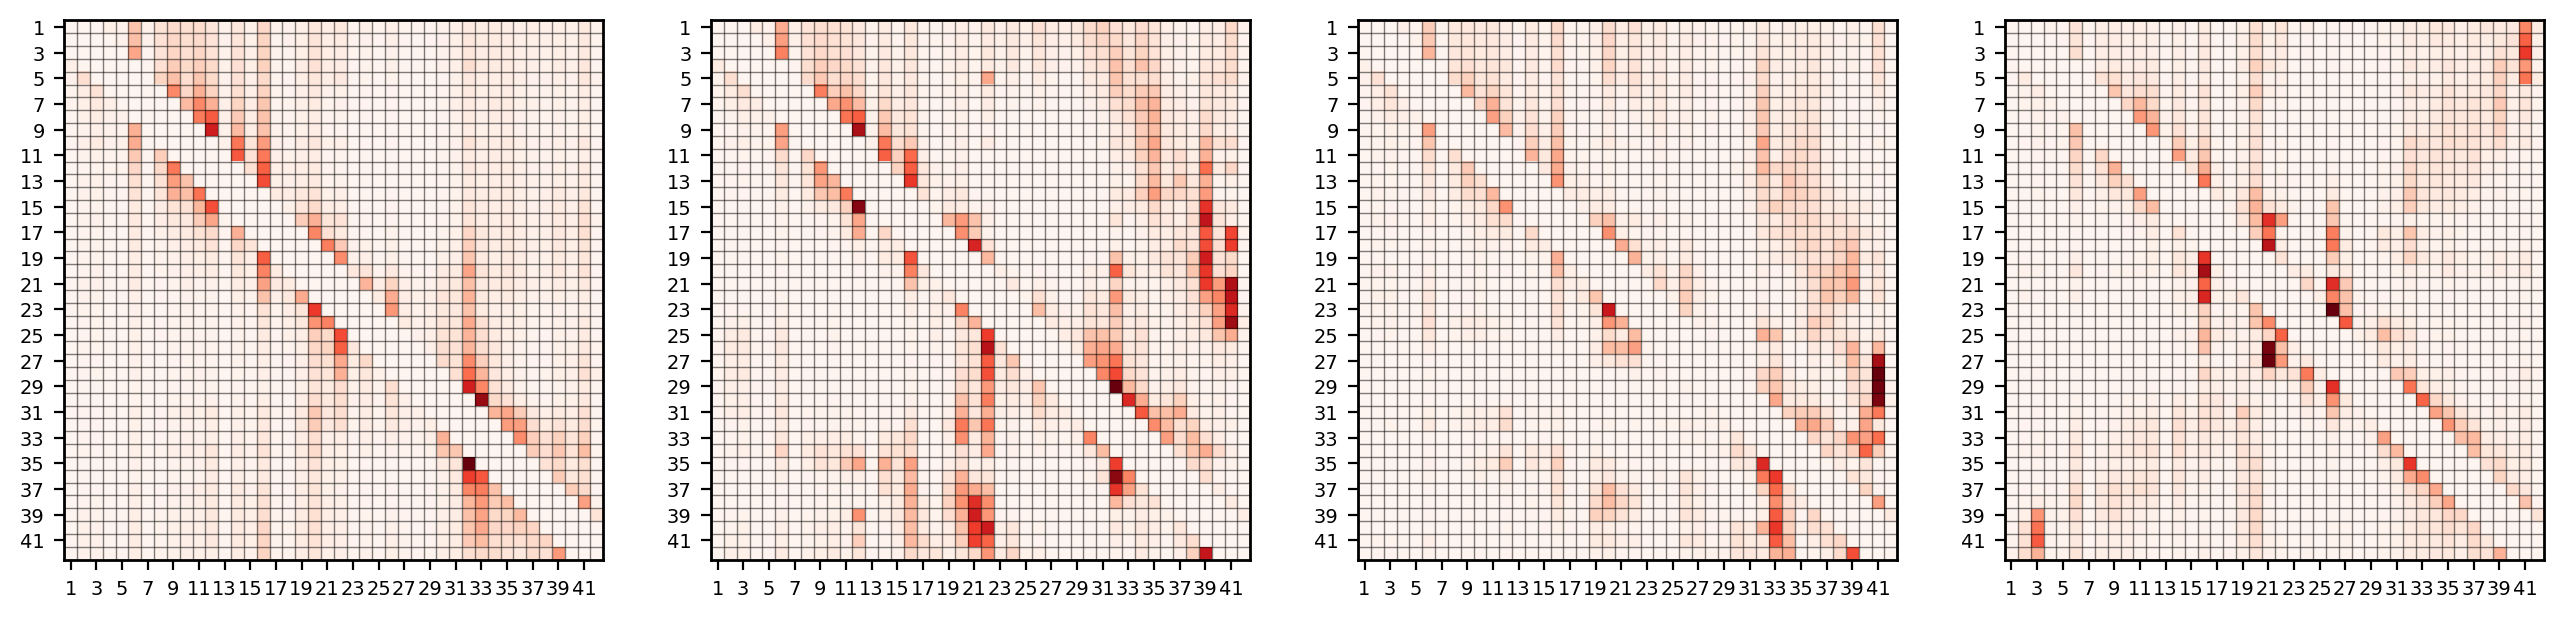

In [89]:
rc('axes', linewidth=1.0)
fontsize = 14
plt.set_cmap('Reds')
fig, axes = plt.subplots(1,n_states,figsize=(16,4),dpi=200)
n_atoms = 42
x_range = np.arange(0,n_atoms,2)
x_label = np.arange(1,n_atoms+1,2)
fontsize = 7
#cbar = plt.colorbar(h, ax=ax, fraction=0.01)
for i in range(n_states):
    axes[i].imshow(scores[i])
    axes[i].hlines(np.arange(0,n_atoms)-0.5,-0.5,n_atoms-0.5,color='k',linewidth=0.5,alpha=0.5)
    axes[i].vlines(np.arange(0,n_atoms)-0.5,-0.5,n_atoms-0.5,color='k',linewidth=0.5,alpha=0.5)
    axes[i].set_xticks(x_range)
    axes[i].set_xticklabels(x_label)
    axes[i].set_yticks(x_range)
    axes[i].set_yticklabels(x_label)
    for tick in axes[i].xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')
    for tick in axes[i].yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
        #tick.label1.set_fontweight('bold')

plt.savefig('trpcage_attn_pp-%i.png'%getidx)

In [90]:
def scale(score):
    score_min = score.min()
    score_max = score.max()
    if score_max == score_min:
        print(score_max)
    ret = (score-score_min)/(score_max-score_min)
    return ret

In [91]:
scores_p = np.stack((scale(scores[0].sum(axis=0)), scale(scores[1].sum(axis=0)), scale(scores[2].sum(axis=0)), scale(scores[3].sum(axis=0)) ))

In [92]:
residues = ['ASP1', 'ALA2', 'GLU3', 'PHE4', 'ARG5', 'HIS6', 'ASP7',
            'SER8', 'GLY9', 'TYR10', 'GLU11', 'VAL12', 'HIS13', 'HIS14',
            'GLN15', 'LYS16', 'LEU17', 'VAL18', 'PHE19', 'PHE20', 'ALA21',
            'GLU22', 'ASP23', 'VAL24', 'GLY25', 'SER26', 'ASN27', 'LYS28',
            'GLY29', 'ALA30', 'ILE31', 'ILE32', 'GLY33', 'LEU34', 'MET35',
            'VAL36', 'GLY37', 'GLY38', 'VAL39', 'VAL40', 'ILE41', 'ALA42']

C:\Users\DS00HY\AppData\Local\Temp\ipykernel_38300\242743234.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([i for i in range(n_states+1)])


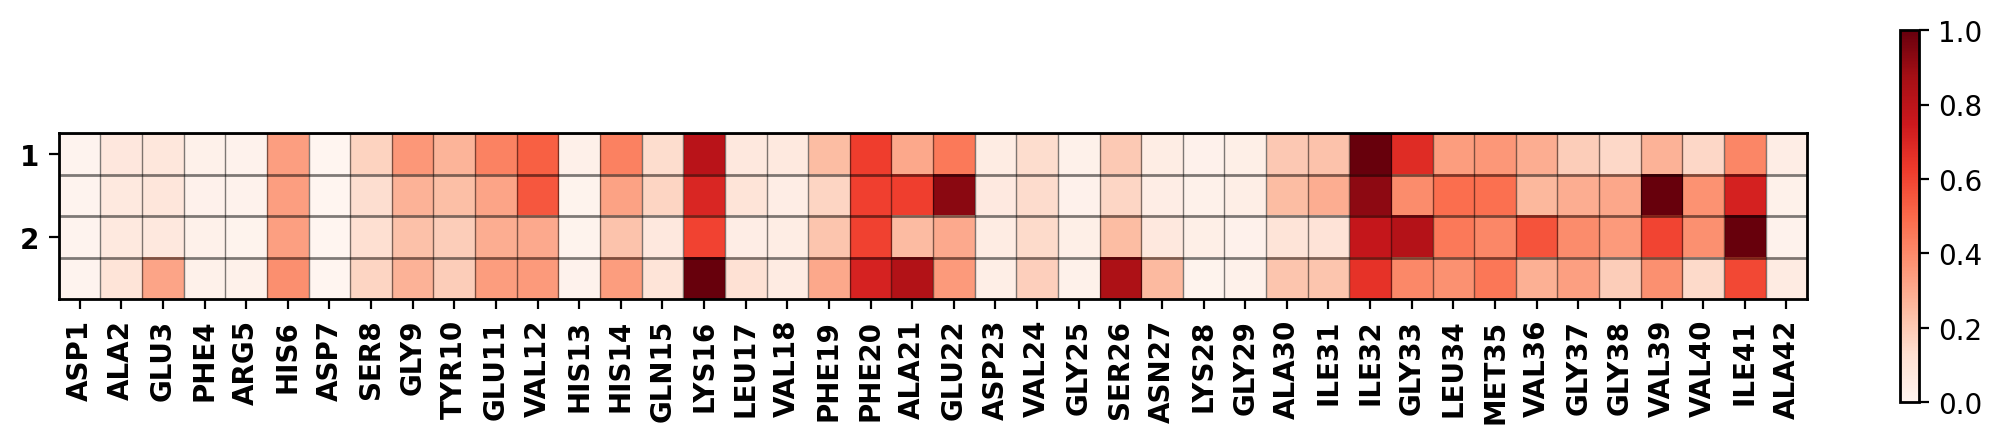

In [93]:
from pylab import *
fig, ax = plt.subplots(1,1,figsize=(12,6),dpi=200)
h=ax.imshow(scores_p)
ax.set_xticks(np.arange(n_atoms))
ax.set_yticklabels([i for i in range(n_states+1)])
ax.set_xticklabels(residues,fontweight='bold', rotation=90)
ax.hlines(np.arange(0,n_states)-0.5,-0.5,n_atoms-0.5,color='k',linewidth=1,alpha=0.5)
ax.vlines(np.arange(0,n_atoms)-0.5,-0.5,n_states-0.5,color='k',linewidth=0.5,alpha=0.5)
cbar = plt.colorbar(h, ax=ax, fraction=0.01)
# for t in cbar.ax.get_yticklabels():
#      t.set_fontsize(25)

fontsize = 10
ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
    
plt.savefig('trpcage_attn_all%i.png'%getidx)

